In [2]:
import torch
from torch import nn
from torch import optim
import torchvision 
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm


In [15]:
class Generator(nn.Module):
  def __init__(self,input_dim,output_dim):
    super(Generator,self).__init__()
    self.model=nn.Sequential(
      nn.Linear(input_dim,256),
      nn.ReLU(True),
      nn.Linear(256,512),
      nn.ReLU(True),
      nn.Linear(512,1024),
      nn.ReLU(True),
      nn.Linear(1024,output_dim),
      nn.Tanh()
    )
  def forward(self,x):
    return self.model(x)

In [4]:
class Discriminator(nn.Module):
  def __init__(self,input_dim):
    super(Discriminator,self).__init__()
    self.model=nn.Sequential(
      nn.Linear(input_dim,1024),
      nn.LeakyReLU(0.2,inplace=True),
      nn.Linear(1024,512),
      nn.LeakyReLU(0.2,inplace=True),
      nn.Linear(512,256),
      nn.LeakyReLU(0.2),
      nn.Linear(256,1),
      nn.Sigmoid()
    )
  def forward(self,x):
    return self.model(x)

In [6]:
transform=transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.5,),(0.5,))
])
train_dataset=torchvision.datasets.MNIST(root='./data',train=True,download=True,transform=transform)
train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=64,shuffle=True)


In [28]:
z_dim=100
device=torch.device("cuda")
G=Generator(z_dim,28*28).to(device)
D=Discriminator(28*28).to(device)
criterion=nn.BCELoss()
G_optimizer=optim.Adam(G.parameters(),lr=0.0002)
D_optimizer=optim.Adam(D.parameters(),lr=0.0002)

In [9]:
def show_images(real,fake,epoch):
  plt.figure(figsize=(10,5))

  plt.subplot(1,2,1)
  plt.imshow(real[0].cpu().numpy().reshape(28,28),cmap="gray")
  plt.title("Real Image")

  plt.subplot(1,2,2)
  plt.imshow(fake[0].cpu().detach().numpy().reshape(28,28),cmap="gray")
  plt.title("Fake Image")
  #plt.savefig(f"epoch_{epoch}.png")
  plt.show()


In [24]:
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples,z_dim).to(device)

In [11]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):

    fake=get_noise(num_images,z_dim,device)
    fake=gen(fake)
    fake_pred=disc(fake.detach())
    fake_loss=criterion(fake_pred,torch.zeros_like(fake_pred))
    real_pred=disc(real)
    real_loss=criterion(real_pred,torch.ones_like(real_pred))
    disc_loss=(fake_loss+real_loss)/2
 
    return disc_loss

In [12]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):

    fake=get_noise(num_images,z_dim,device)
    fake=gen(fake)
    fake_pred=disc(fake)
    gen_loss=criterion(fake_pred,torch.ones_like(fake_pred))
   
    return gen_loss,fake

In [25]:
def train(G,D,G_optimizer,D_optimizer,criterion,device,train_loader,z_dim,epochs):
   for epoch in range(epochs):
     Generator_loss=[]
     Discriminator_loss=[]
     for real,_ in tqdm(train_loader,desc=f"Epoch {epoch+1}/{epochs}",leave=True):
        batch_size=len(real)
        real=real.view(batch_size,-1).to(device)
        D_optimizer.zero_grad()
        D_loss=get_disc_loss(G,D,criterion,real,batch_size,z_dim,device)
        D_loss.backward()
        D_optimizer.step()
        G_optimizer.zero_grad()
        gen_loss,fake=get_gen_loss(G,D,criterion,batch_size,z_dim,device)
        gen_loss.backward()
        G_optimizer.step()
        Discriminator_loss.append(D_loss.item())
        Generator_loss.append(gen_loss.item())
     print(f"Epoch [{epoch+1}/{epochs}] D_loss: {torch.tensor(Discriminator_loss).mean():.4f} G_loss: {torch.tensor(Generator_loss).mean():.4f}")
     show_images(real.view(batch_size, 1, 28, 28), fake.view(batch_size, 1, 28, 28), epoch)
    

Epoch 1/50: 100%|██████████| 938/938 [00:20<00:00, 45.82it/s]


Epoch [1/50] D_loss: 0.5215 G_loss: 1.2811


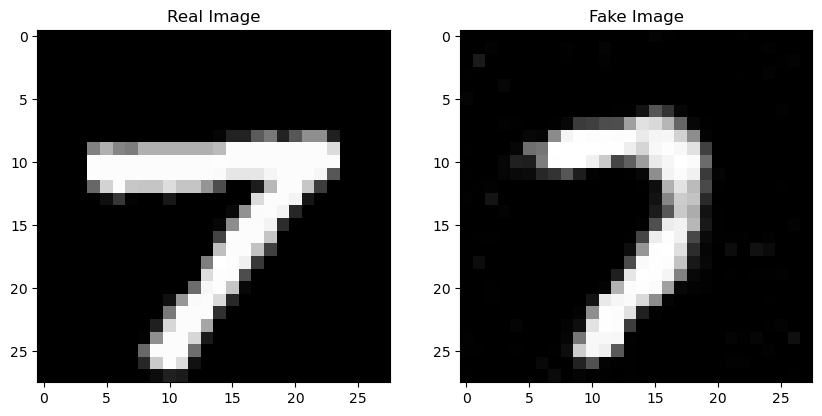

Epoch 2/50: 100%|██████████| 938/938 [00:20<00:00, 46.24it/s]


Epoch [2/50] D_loss: 0.5231 G_loss: 1.2709


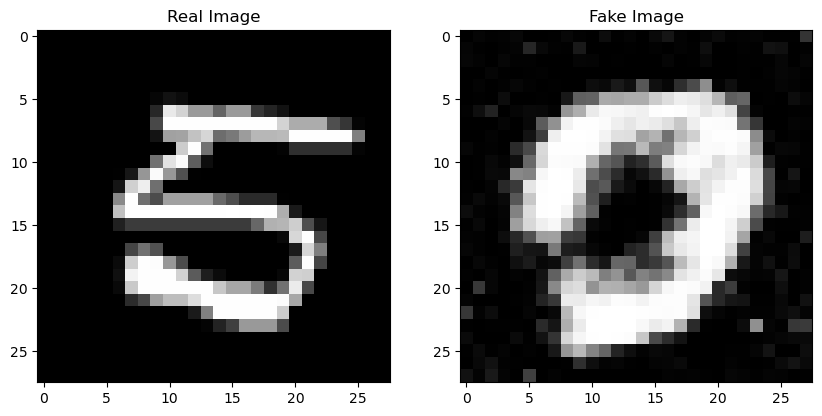

Epoch 3/50: 100%|██████████| 938/938 [00:20<00:00, 45.37it/s]


Epoch [3/50] D_loss: 0.5252 G_loss: 1.2728


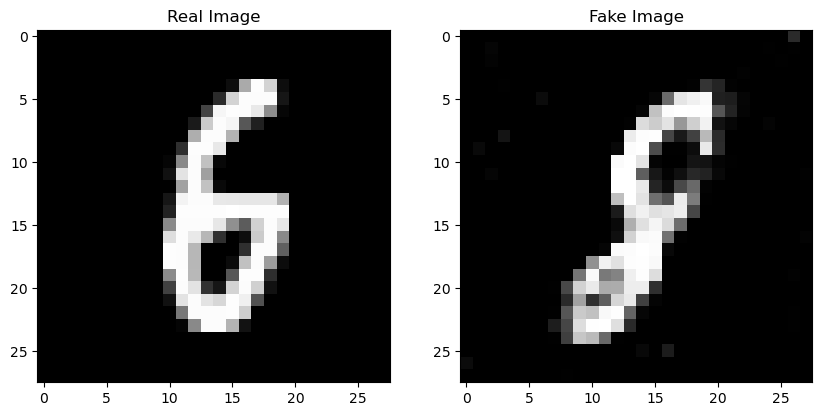

Epoch 4/50: 100%|██████████| 938/938 [00:20<00:00, 45.74it/s]


Epoch [4/50] D_loss: 0.5285 G_loss: 1.2714


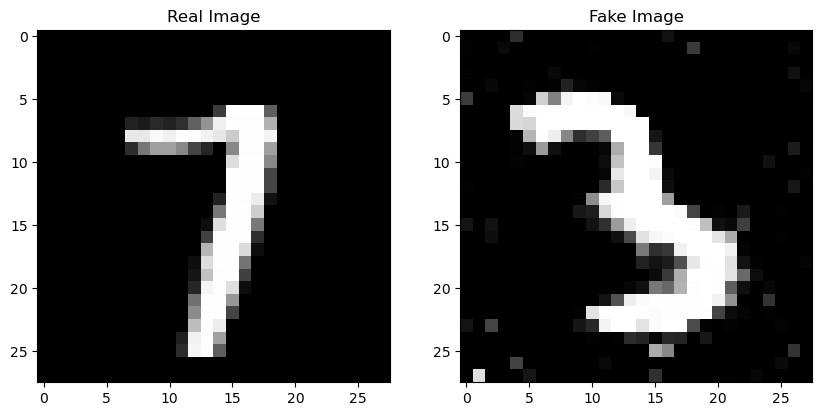

Epoch 5/50: 100%|██████████| 938/938 [00:20<00:00, 45.59it/s]


Epoch [5/50] D_loss: 0.5333 G_loss: 1.2660


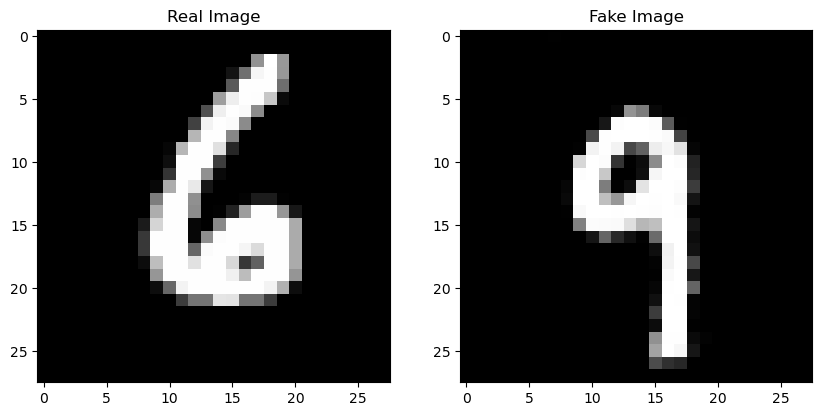

Epoch 6/50: 100%|██████████| 938/938 [00:21<00:00, 44.27it/s]


Epoch [6/50] D_loss: 0.5230 G_loss: 1.2605


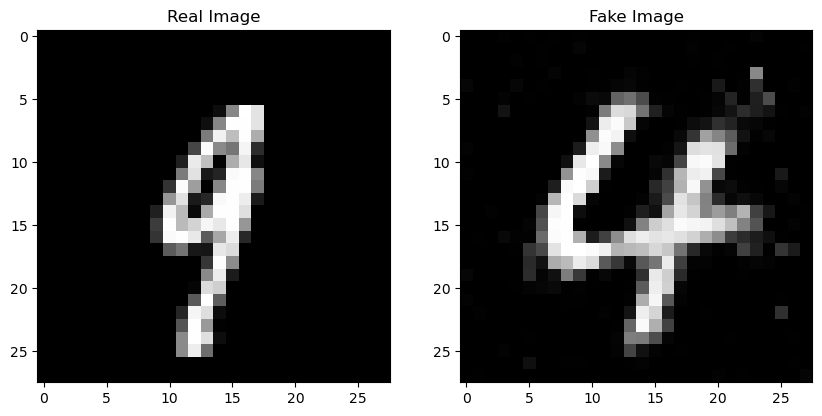

Epoch 7/50: 100%|██████████| 938/938 [00:22<00:00, 41.83it/s]


Epoch [7/50] D_loss: 0.5233 G_loss: 1.2589


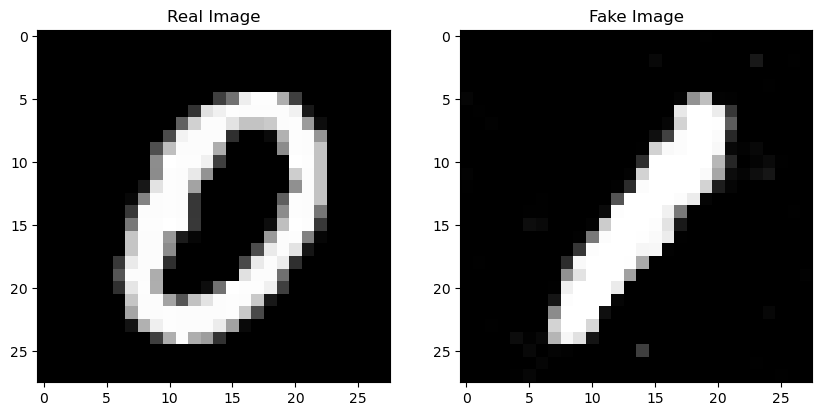

Epoch 8/50: 100%|██████████| 938/938 [00:21<00:00, 42.65it/s]


Epoch [8/50] D_loss: 0.5209 G_loss: 1.2467


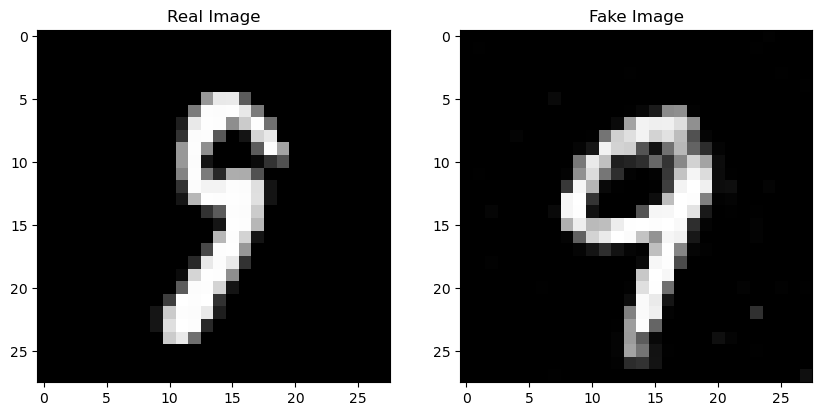

Epoch 9/50: 100%|██████████| 938/938 [00:22<00:00, 42.49it/s]


Epoch [9/50] D_loss: 0.5155 G_loss: 1.2707


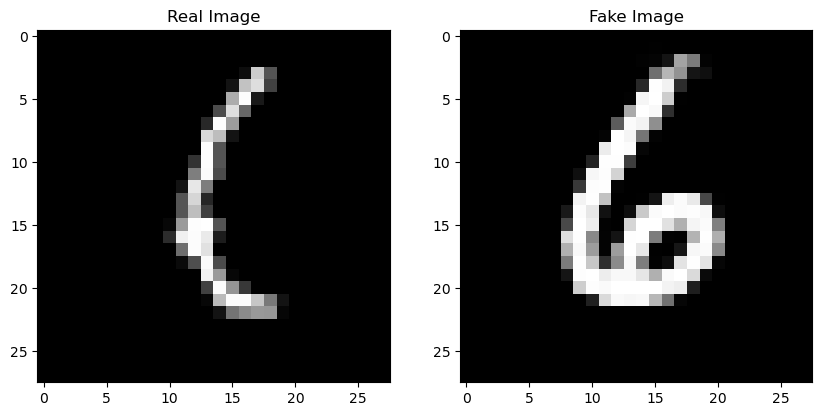

Epoch 10/50: 100%|██████████| 938/938 [00:21<00:00, 42.72it/s]


Epoch [10/50] D_loss: 0.5220 G_loss: 1.2973


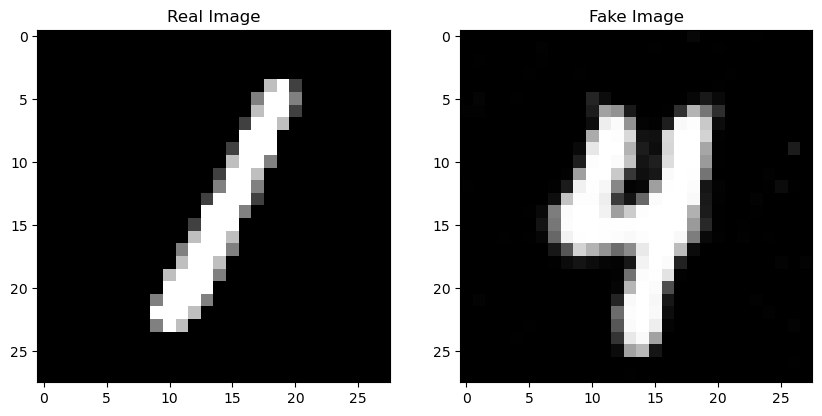

Epoch 11/50: 100%|██████████| 938/938 [00:21<00:00, 42.88it/s]


Epoch [11/50] D_loss: 0.5222 G_loss: 1.2941


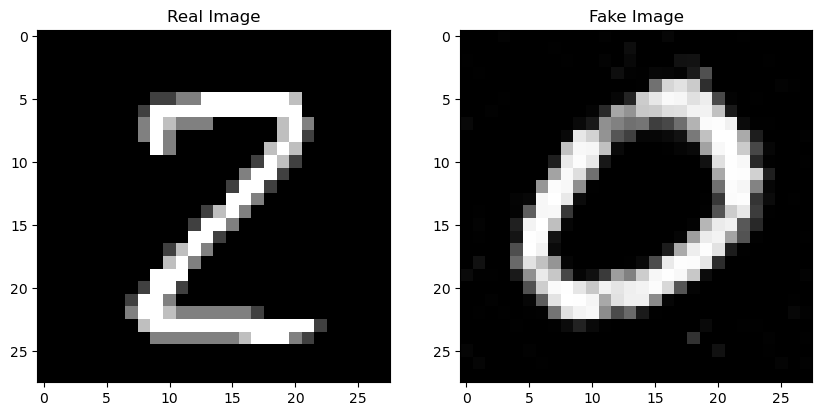

Epoch 12/50: 100%|██████████| 938/938 [00:21<00:00, 42.85it/s]


Epoch [12/50] D_loss: 0.5177 G_loss: 1.2750


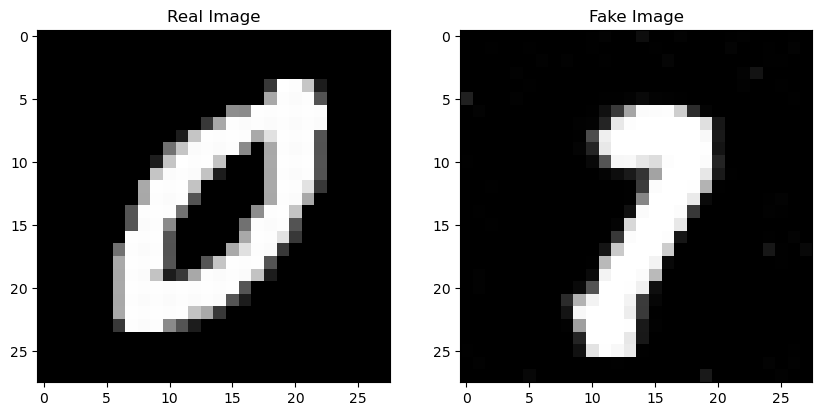

Epoch 13/50: 100%|██████████| 938/938 [00:21<00:00, 42.91it/s]


Epoch [13/50] D_loss: 0.5187 G_loss: 1.2834


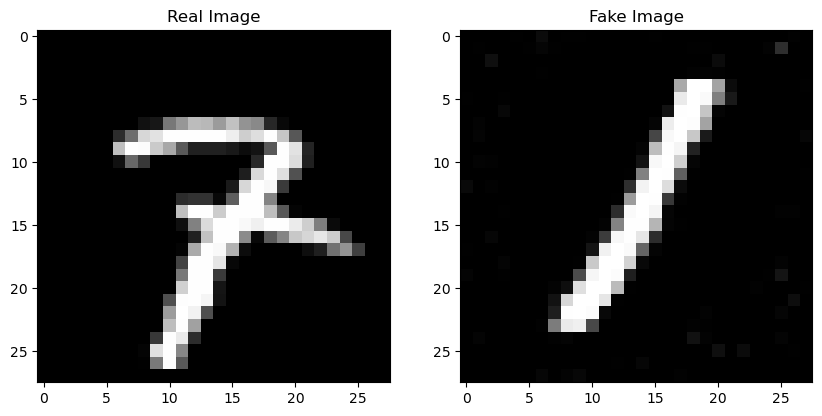

Epoch 14/50: 100%|██████████| 938/938 [00:22<00:00, 41.29it/s]


Epoch [14/50] D_loss: 0.5191 G_loss: 1.2870


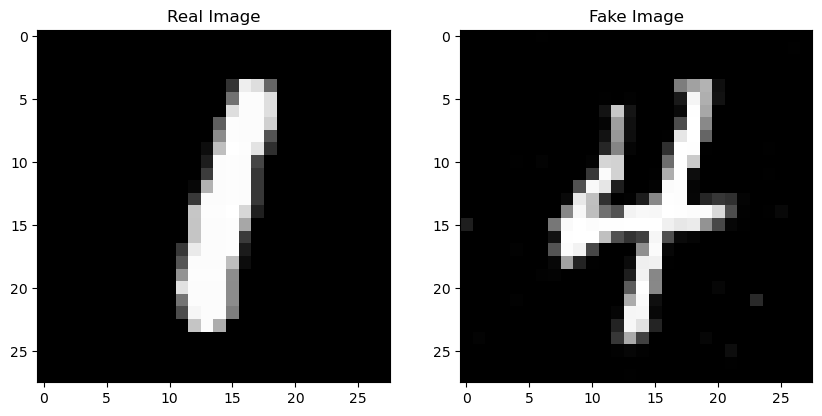

Epoch 15/50: 100%|██████████| 938/938 [00:24<00:00, 38.51it/s]


Epoch [15/50] D_loss: 0.5206 G_loss: 1.2817


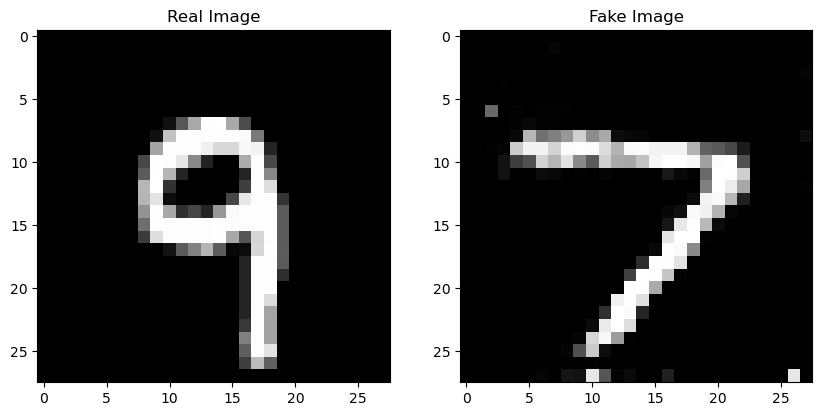

Epoch 16/50: 100%|██████████| 938/938 [00:27<00:00, 33.66it/s]


Epoch [16/50] D_loss: 0.5244 G_loss: 1.2823


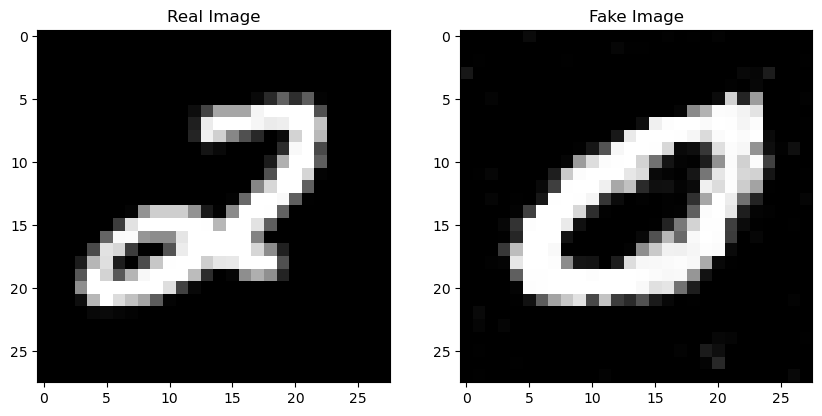

Epoch 17/50: 100%|██████████| 938/938 [00:24<00:00, 38.29it/s]


Epoch [17/50] D_loss: 0.5173 G_loss: 1.2801


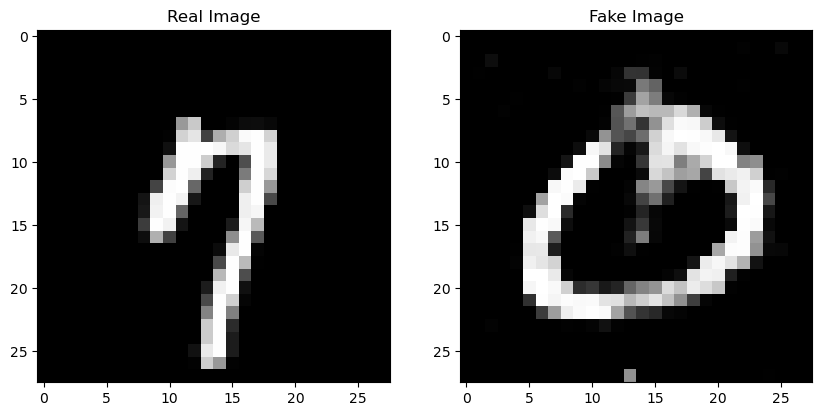

Epoch 18/50: 100%|██████████| 938/938 [00:25<00:00, 37.52it/s]


Epoch [18/50] D_loss: 0.5183 G_loss: 1.2710


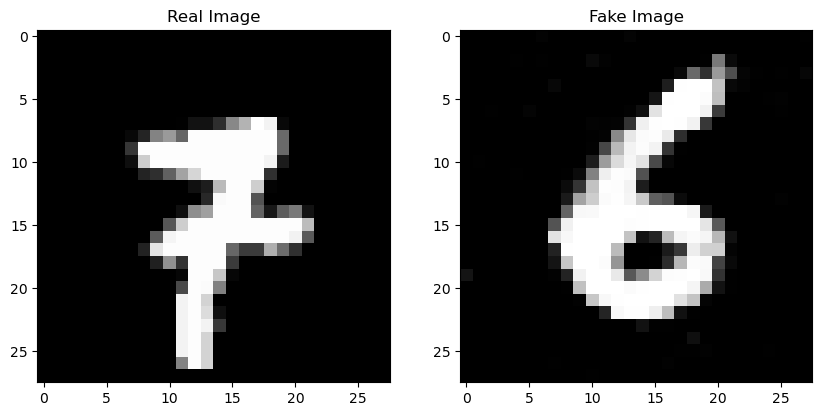

Epoch 19/50: 100%|██████████| 938/938 [00:25<00:00, 37.50it/s]


Epoch [19/50] D_loss: 0.5178 G_loss: 1.2825


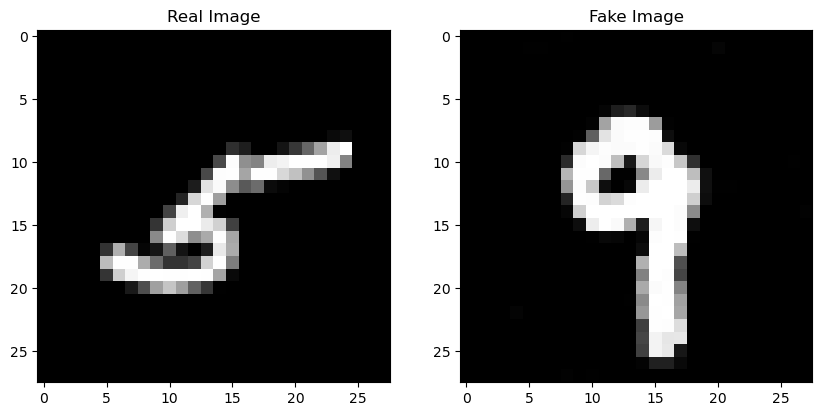

Epoch 20/50: 100%|██████████| 938/938 [00:23<00:00, 39.41it/s]


Epoch [20/50] D_loss: 0.5145 G_loss: 1.2842


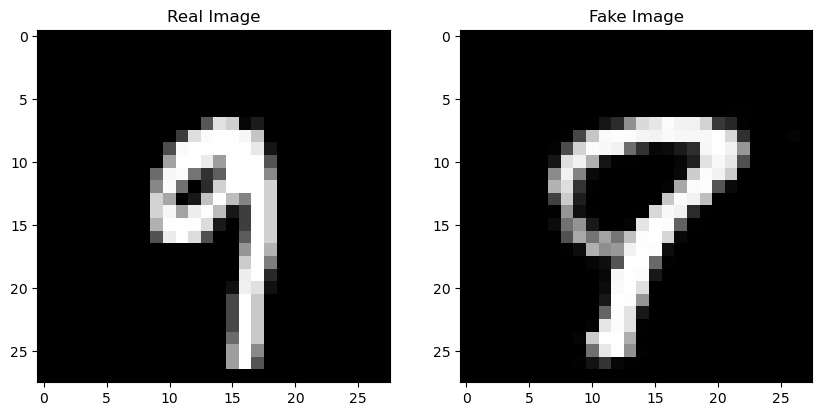

Epoch 21/50: 100%|██████████| 938/938 [00:22<00:00, 40.85it/s]


Epoch [21/50] D_loss: 0.5129 G_loss: 1.2795


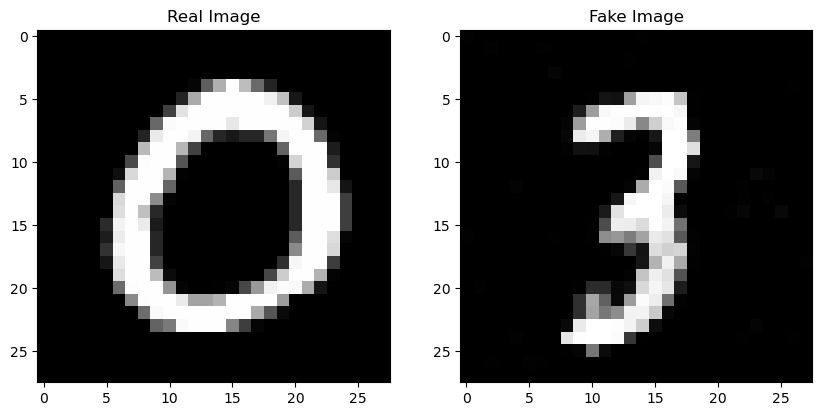

Epoch 22/50: 100%|██████████| 938/938 [00:22<00:00, 41.72it/s]


Epoch [22/50] D_loss: 0.5144 G_loss: 1.2997


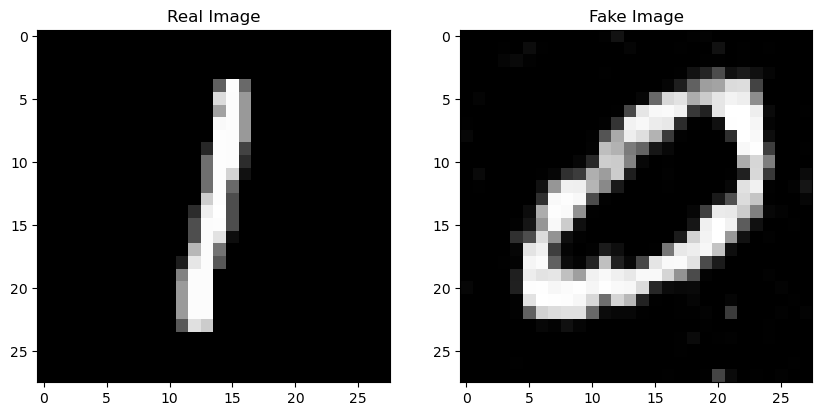

Epoch 23/50: 100%|██████████| 938/938 [00:22<00:00, 41.64it/s]


Epoch [23/50] D_loss: 0.5110 G_loss: 1.2794


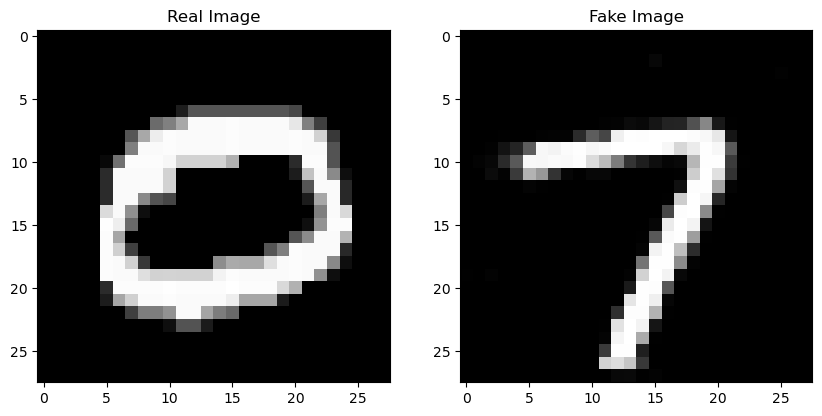

Epoch 24/50: 100%|██████████| 938/938 [00:22<00:00, 42.30it/s]


Epoch [24/50] D_loss: 0.5100 G_loss: 1.3150


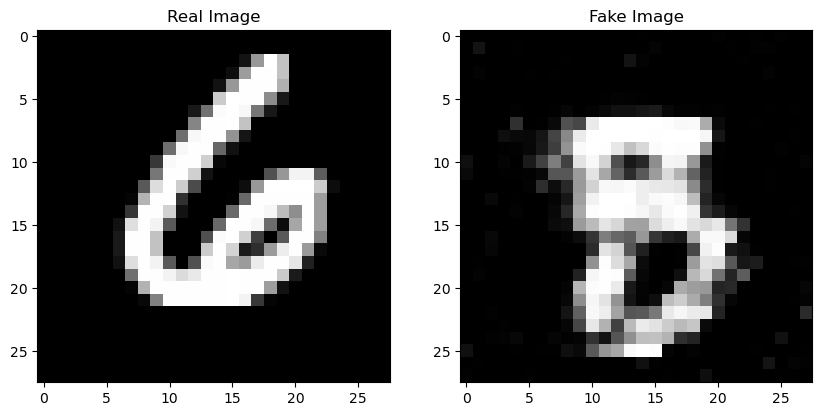

Epoch 25/50: 100%|██████████| 938/938 [00:21<00:00, 43.35it/s]


Epoch [25/50] D_loss: 0.5078 G_loss: 1.3052


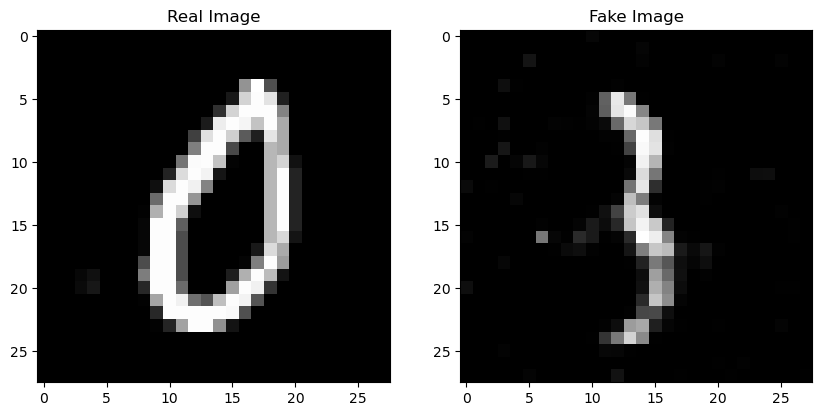

Epoch 26/50: 100%|██████████| 938/938 [00:21<00:00, 42.81it/s]


Epoch [26/50] D_loss: 0.5107 G_loss: 1.2960


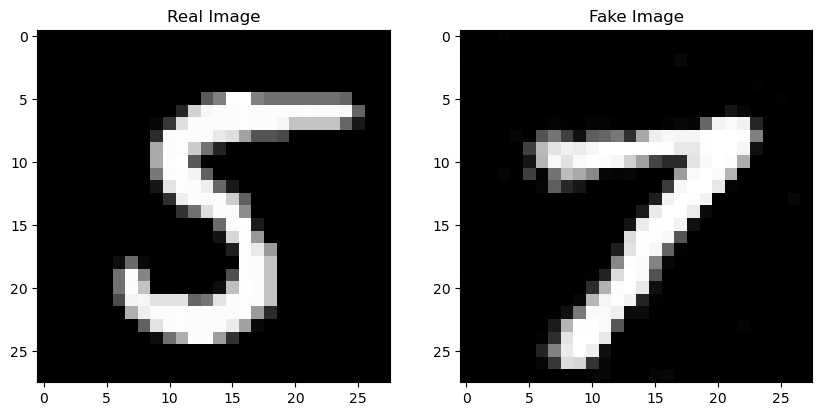

Epoch 27/50: 100%|██████████| 938/938 [00:22<00:00, 41.28it/s]


Epoch [27/50] D_loss: 0.5105 G_loss: 1.3140


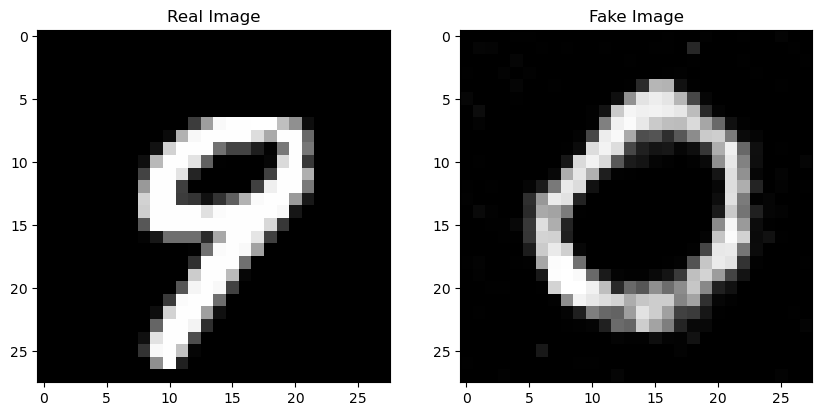

Epoch 28/50: 100%|██████████| 938/938 [00:21<00:00, 43.48it/s]


Epoch [28/50] D_loss: 0.5100 G_loss: 1.2950


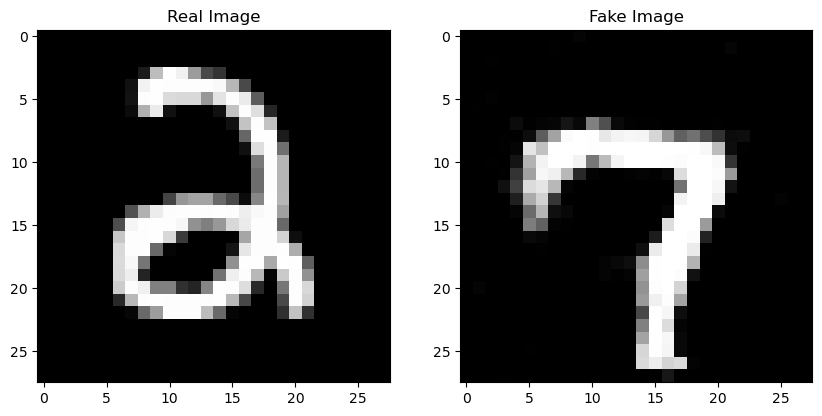

Epoch 29/50: 100%|██████████| 938/938 [00:22<00:00, 42.47it/s]


Epoch [29/50] D_loss: 0.5054 G_loss: 1.3284


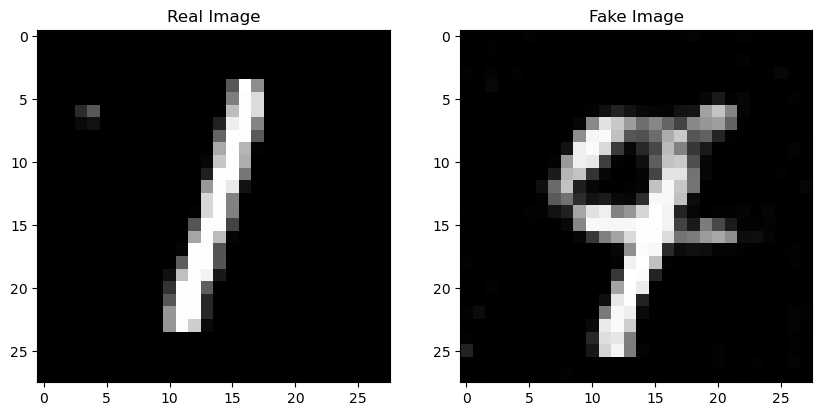

Epoch 30/50: 100%|██████████| 938/938 [00:22<00:00, 42.62it/s]


Epoch [30/50] D_loss: 0.5067 G_loss: 1.3162


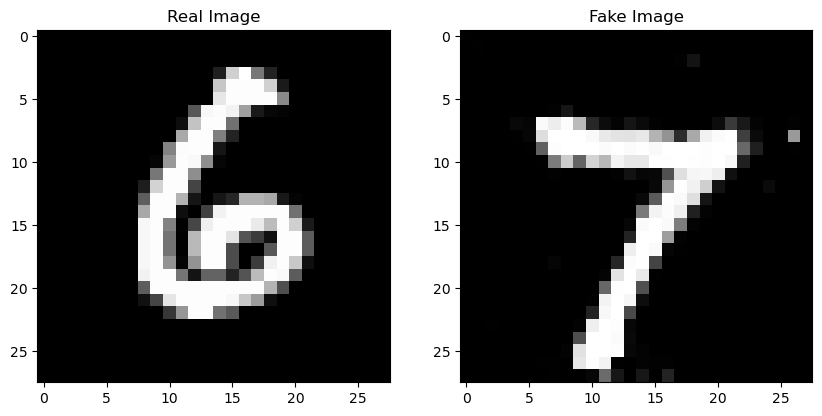

Epoch 31/50: 100%|██████████| 938/938 [00:22<00:00, 42.31it/s]


Epoch [31/50] D_loss: 0.5021 G_loss: 1.3207


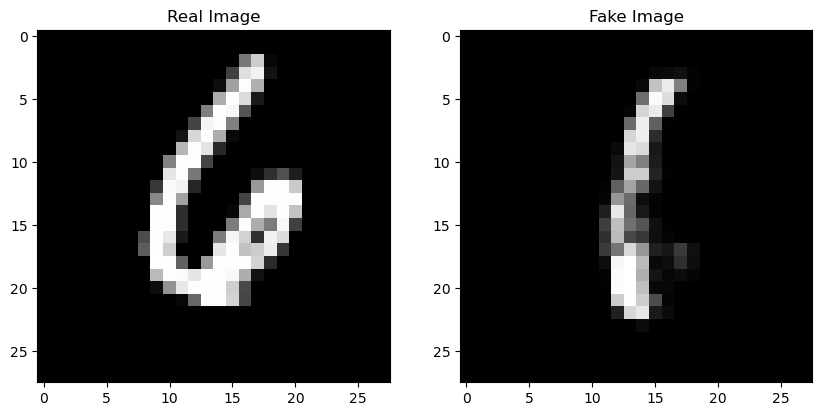

Epoch 32/50: 100%|██████████| 938/938 [00:24<00:00, 38.42it/s]


Epoch [32/50] D_loss: 0.5048 G_loss: 1.3218


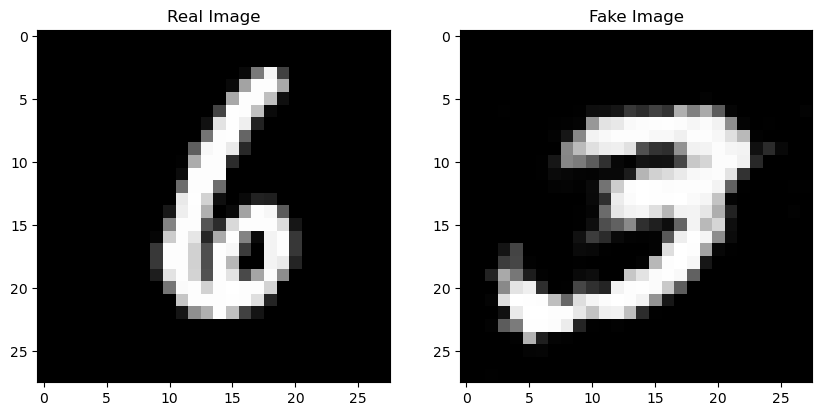

Epoch 33/50: 100%|██████████| 938/938 [00:25<00:00, 36.55it/s]


Epoch [33/50] D_loss: 0.4996 G_loss: 1.3415


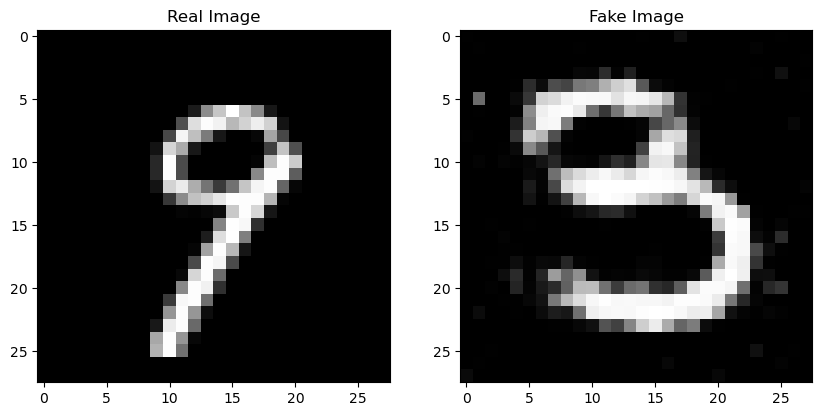

Epoch 34/50: 100%|██████████| 938/938 [00:24<00:00, 38.03it/s]


Epoch [34/50] D_loss: 0.5014 G_loss: 1.3368


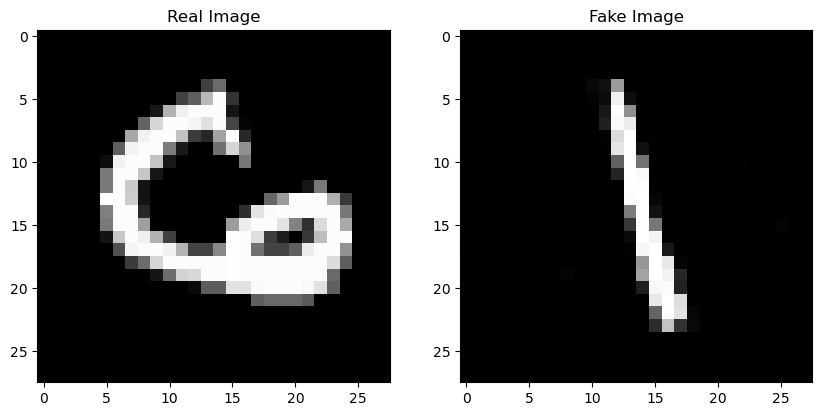

Epoch 35/50: 100%|██████████| 938/938 [00:23<00:00, 39.90it/s]


Epoch [35/50] D_loss: 0.5037 G_loss: 1.3250


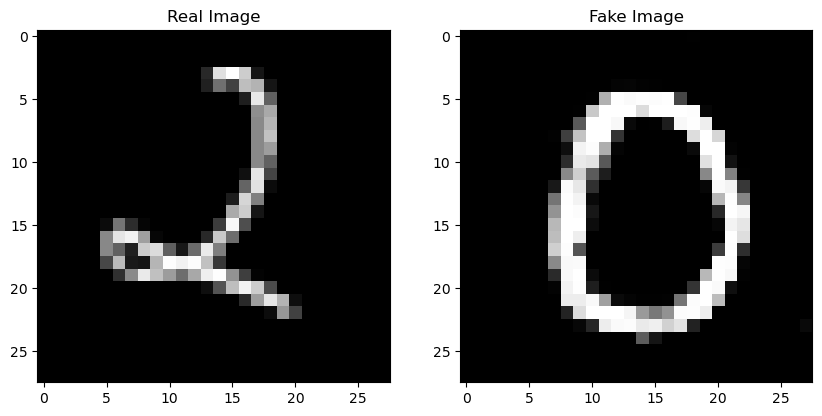

Epoch 36/50: 100%|██████████| 938/938 [00:22<00:00, 41.58it/s]


Epoch [36/50] D_loss: 0.4982 G_loss: 1.3507


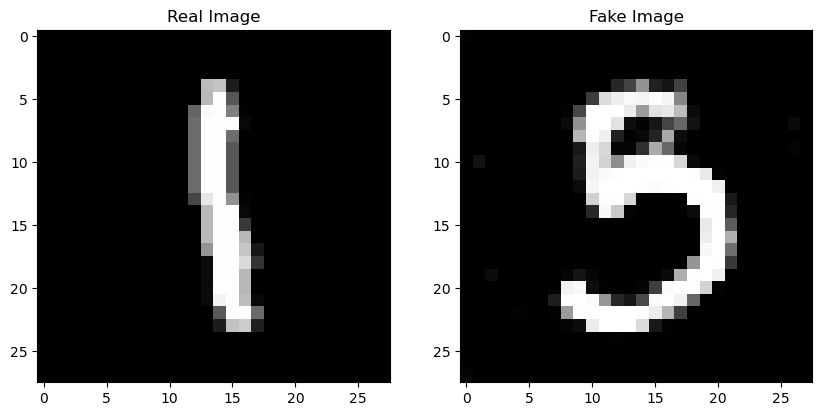

Epoch 37/50: 100%|██████████| 938/938 [00:22<00:00, 41.73it/s]


Epoch [37/50] D_loss: 0.4980 G_loss: 1.3369


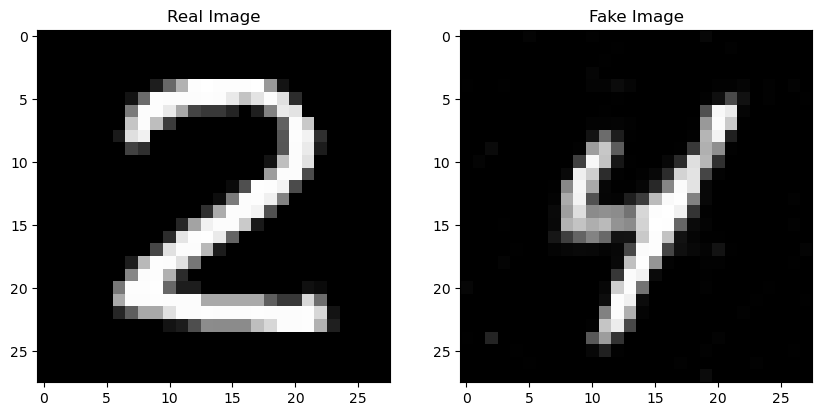

Epoch 38/50: 100%|██████████| 938/938 [00:22<00:00, 41.41it/s]


Epoch [38/50] D_loss: 0.5001 G_loss: 1.3538


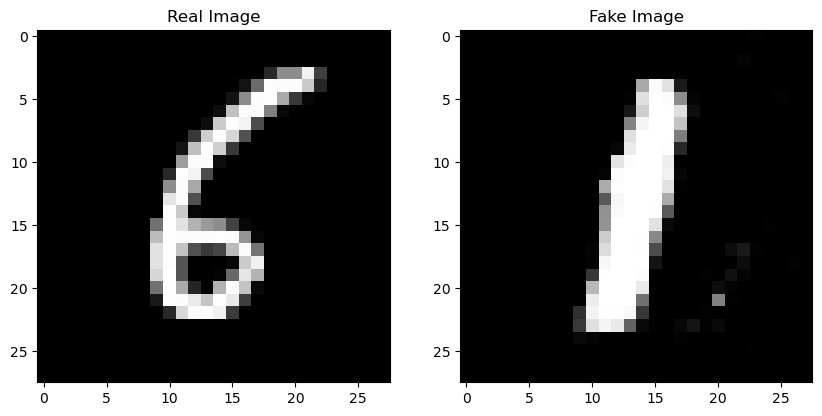

Epoch 39/50: 100%|██████████| 938/938 [00:22<00:00, 41.22it/s]


Epoch [39/50] D_loss: 0.4955 G_loss: 1.3359


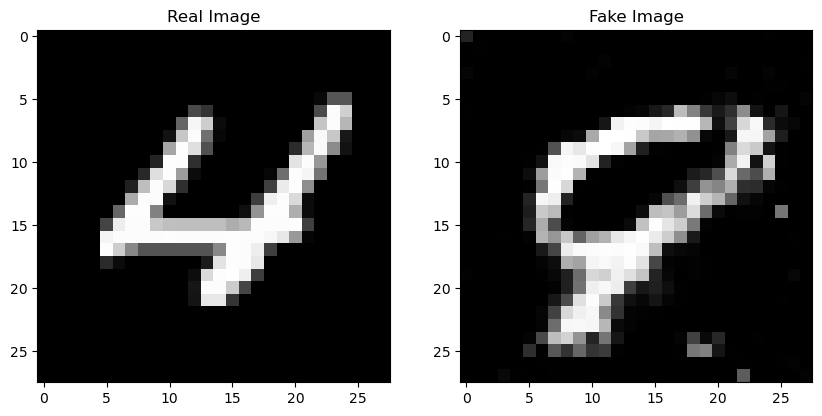

Epoch 40/50: 100%|██████████| 938/938 [00:22<00:00, 42.01it/s]


Epoch [40/50] D_loss: 0.4953 G_loss: 1.3708


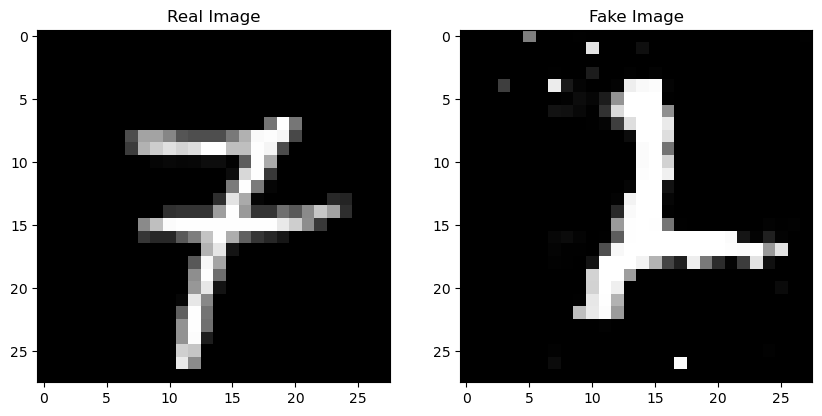

Epoch 41/50: 100%|██████████| 938/938 [00:21<00:00, 44.14it/s]


Epoch [41/50] D_loss: 0.4917 G_loss: 1.3607


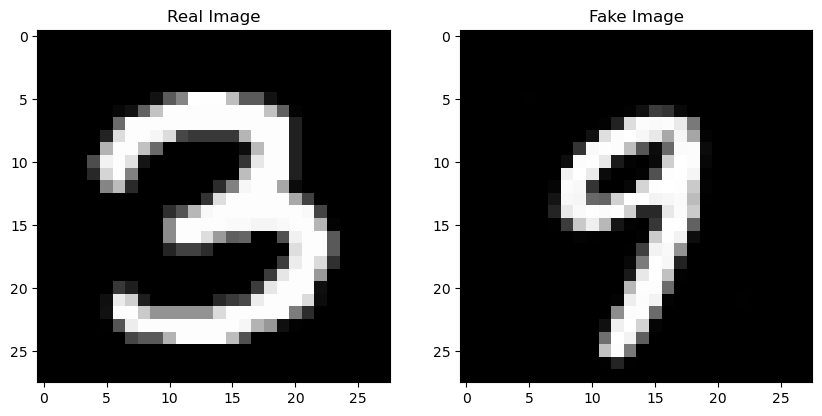

Epoch 42/50: 100%|██████████| 938/938 [00:22<00:00, 41.38it/s]


Epoch [42/50] D_loss: 0.4929 G_loss: 1.3737


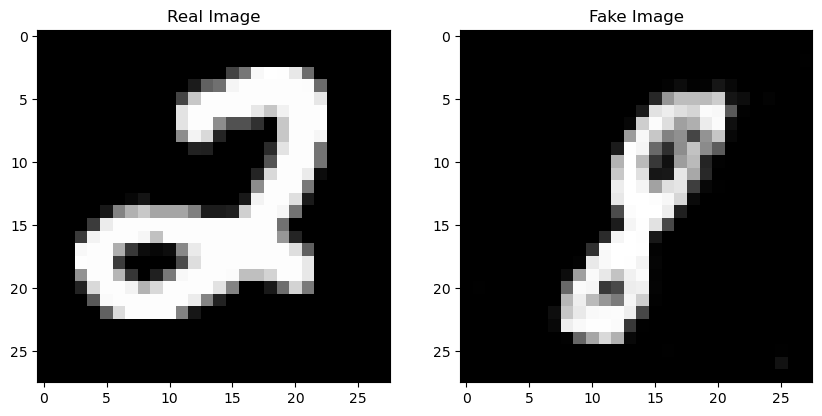

Epoch 43/50: 100%|██████████| 938/938 [00:22<00:00, 42.22it/s]


Epoch [43/50] D_loss: 0.4914 G_loss: 1.3604


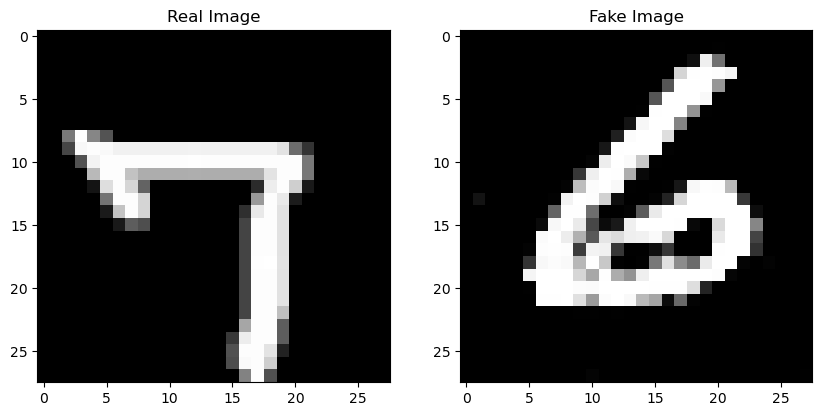

Epoch 44/50: 100%|██████████| 938/938 [00:21<00:00, 43.90it/s]


Epoch [44/50] D_loss: 0.4894 G_loss: 1.3786


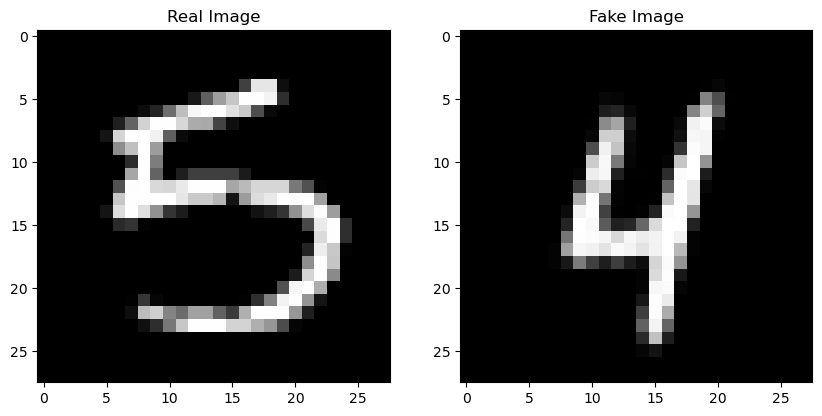

Epoch 45/50: 100%|██████████| 938/938 [00:21<00:00, 44.25it/s]


Epoch [45/50] D_loss: 0.4905 G_loss: 1.3883


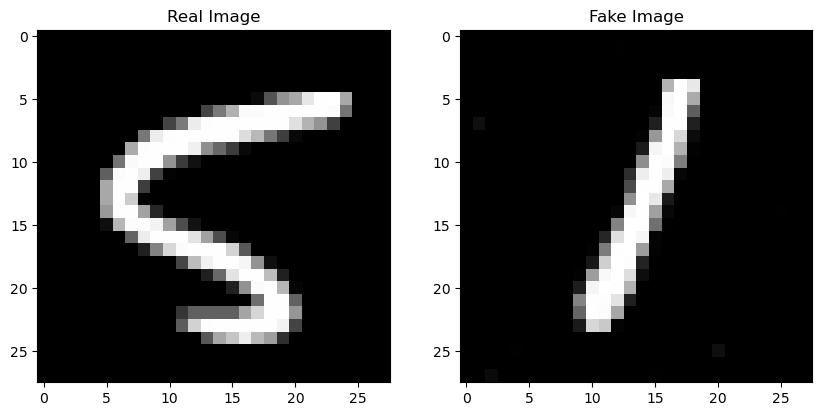

Epoch 46/50: 100%|██████████| 938/938 [00:21<00:00, 44.13it/s]


Epoch [46/50] D_loss: 0.4884 G_loss: 1.3764


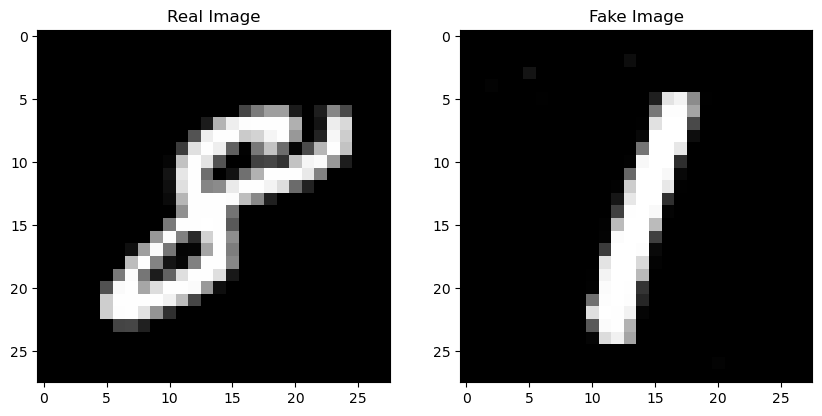

Epoch 47/50: 100%|██████████| 938/938 [00:21<00:00, 44.21it/s]


Epoch [47/50] D_loss: 0.4887 G_loss: 1.3797


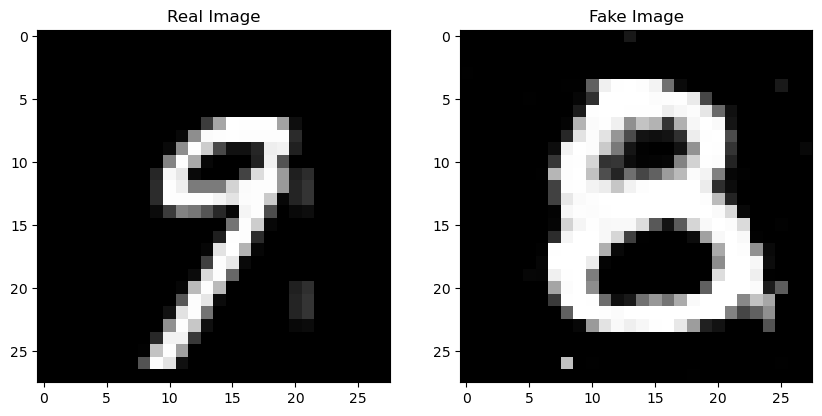

Epoch 48/50: 100%|██████████| 938/938 [00:21<00:00, 44.10it/s]


Epoch [48/50] D_loss: 0.4875 G_loss: 1.3957


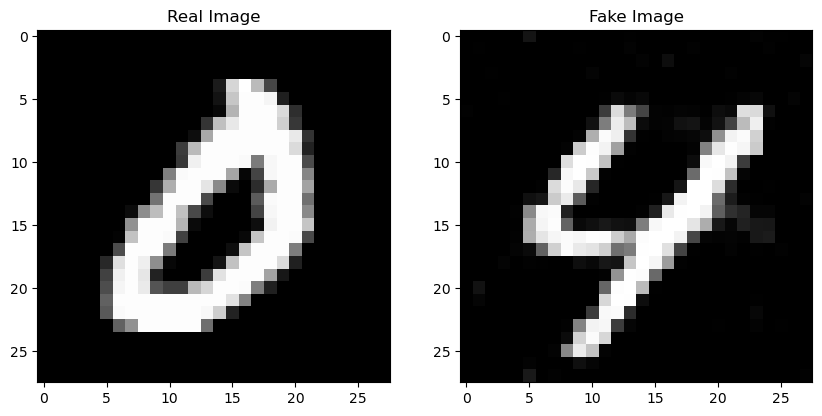

Epoch 49/50: 100%|██████████| 938/938 [00:22<00:00, 40.86it/s]


Epoch [49/50] D_loss: 0.4860 G_loss: 1.3881


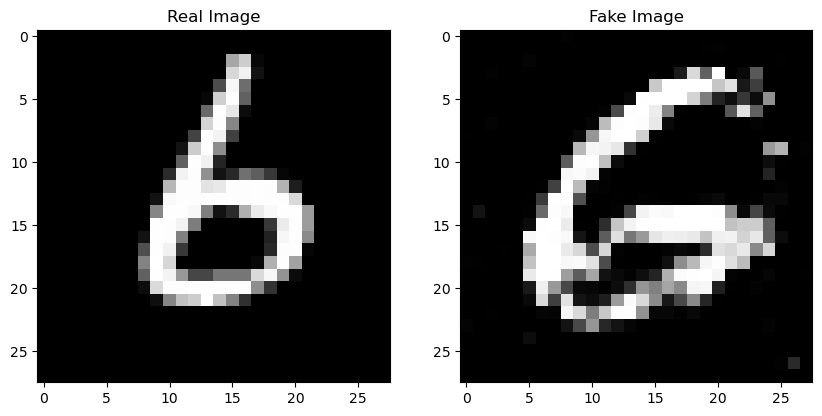

Epoch 50/50: 100%|██████████| 938/938 [00:23<00:00, 39.50it/s]


Epoch [50/50] D_loss: 0.4834 G_loss: 1.3928


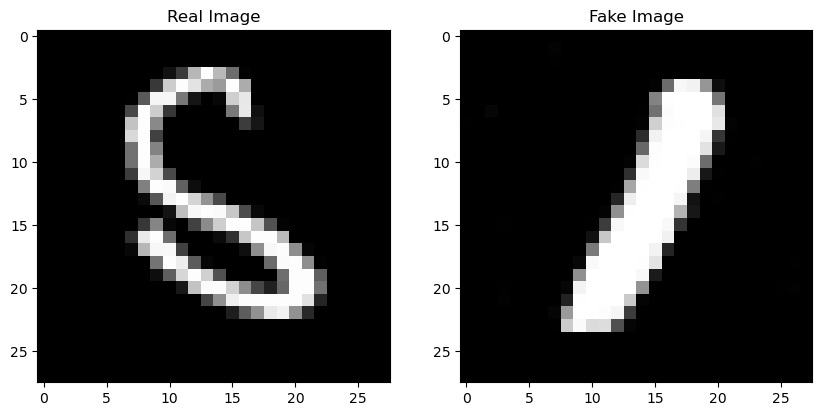

In [32]:
train(G,D,G_optimizer,D_optimizer,criterion,device,train_loader,z_dim,50)